# Introduction

In this project, we will implement a tags recommendation system for *StackOverflow* questions.\
*StackOverflow* is a reknown platform for questions and answers about programmation.
* In the first notebook, we will extract the required data using the *StackExchange data explorer* tool, and explore the data.
* In the second notebook, we will implement various *machine learning algorithms* and select the suitable inference model to deploy an *API endpoint*.

# Environment

In [26]:
import pandas as pd
import numpy as np
from nltk.probability import FreqDist
from IPython.display import Image
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss, cohen_kappa_score, matthews_corrcoef
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from DataGT.PCA import display_scree_plot
from sklearn.decomposition import TruncatedSVD
import gensim
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import TfidfModel
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel
from imp import reload
from xgboost import XGBClassifier
from ttictoc import tic, toc
from joblib import dump

In [3]:
df = pd.read_csv('./data/df.csv')

df.head()

,Id,Title,Body,Tags,Body_tokens,Title_tokens,Tags_tokens,Title_Body_tokens
0,4,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...,"use,change,opacity,code,application,error,work...",convert,"c#,floating-point,type-conversion,double,decimal","convert,use,change,opacity,code,application,er..."
1,11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,"value,display,time,hour,day,month","calculate,time","c#,datetime,time,datediff,relative-time-span","calculate,time,value,display,time,hour,day,month"
2,13,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...,"way,web,server,determine,user,timezone,page,he...","determine,user,timezone","html,browser,timezone,user-agent,timezone-offset","determine,user,timezone,way,web,server,determi..."
3,19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...,"way,obtain,value,π,challenge,way,involve,const...","way,get,value,π","performance,algorithm,language-agnostic,unix,pi","way,get,value,π,way,obtain,value,π,challenge,w..."
4,25,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>,"issue,socket,work,c++,z/os,get,time,error,some...","use,c,socket,api,c++,z/os","c++,c,sockets,mainframe,zos","use,c,socket,api,c++,z/os,issue,socket,work,c+..."


# Preprocessing

In order to pass our data to the various models, we need to process it and transform it into numerical features.
* First, we apply a split to generate a *traning* and a *test set*. The transformers will be fit on the training data to transform the test data, thus avoiding *data leakage*.
* In order to limit dimensionality, we detect the terms with the highest frequencies on the train set and keep the corresponding terms in the test set. We apply this methodology for both the question *content* and *tags*.
* We filter the *corpus* in order to keep the documents that have at least 3 *top tags* to improve the performance of the models.
* We vectorize the *content* using a *TfidVectorizer*.
* We vectorize the *tags* using a *MultiLabelBinarizer*.
* In order to further reduce dimentionality, we apply a *TruncatedSVD* on the question *content* vectors.

The following schema sums up the applied transformations:

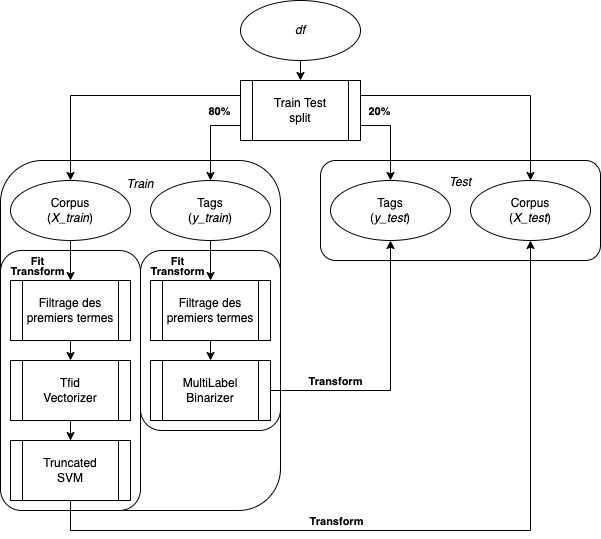

In [4]:
Image(filename='processing.png')

In [5]:
def gen_frequencies(series):

    dist = FreqDist(','.join(series).split(','))

    return dist

We create a function to extract the top terms from the frequencies dictionary:

In [6]:
def extract_top(frequencies:dict, n_top:int):

    top_values = pd.DataFrame(
        {'Tag':frequencies.keys(), 'Frequency':frequencies.values()}
        ).sort_values('Frequency', ascending=False).head(n_top)['Tag'].values
    
    return top_values

We create a function to keep only the top terms for each value of a *series*:

In [7]:
def keep_top(series:pd.Series, top_values:list):
    
    series = series.apply(lambda cell: list(set(cell.split(',')).intersection(top_values)))

    return series

We develop a *python class* to:
* Fit the transformers,
* Transform the dataset,
* Transform the predictions of the models back into human readable format.

We dispose of a limited processing power and choose to generate a *X set* with 600 features reduced to 350, and a *y set* 200 *tags*:

In [20]:
class DatasetTransformer():

    def __init__(self, df:pd.DataFrame, X:str, y:str):

        self.dataset = df
        self.X = X
        self.y = y
        self.X_values = df[X]
        self.y_values = df[y]
        self.test_df = None
        self.multi_label_binarizer = None
        self.tfid_vectorizer = None
        self.truncated_svd = None
    
    def gen_train_test(self, top_tags, max_features, n_components):
        
        # Apply a train test split on the data
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_values,
            self.y_values,
            test_size=0.2,
            random_state=42)
        
        # y processing

        # Calculate the tags frequencies
        y_frequencies = gen_frequencies(y_train)
        # Extract the top tags
        self.top_tags = extract_top(y_frequencies, top_tags)
        # Keep only the top tags from the target
        y_train = keep_top(y_train, self.top_tags)
        y_test = keep_top(y_test, self.top_tags)

        # Drop the empty rows we might have generated
        train_drop = y_train[y_train.map(len)<3].keys()
        test_drop = y_test[y_test.map(len)<3].keys()
        y_train.drop(train_drop,inplace=True)
        y_test.drop(test_drop,inplace=True)

        self.X_train_raw = X_train
        self.X_test_raw = X_test
        self.y_train_raw = y_train
        self.y_test_raw = y_test

        print(f'Dropped Train samples: {train_drop.shape[0]}')
        print(f'Dropped Test samples: {test_drop.shape[0]}')

        # Binarize the target
        self.multi_label_binarizer = MultiLabelBinarizer(classes=self.top_tags)
        y_train_matrix = self.multi_label_binarizer.fit_transform(y_train)
        y_test_matrix = self.multi_label_binarizer.transform(y_test)
        
        # Convert the matrixes back to pandas DataFrames
        tags = self.multi_label_binarizer.classes_
        y_train = pd.DataFrame(
            data=y_train_matrix,
            index=y_train.index,
            columns=tags)
        y_test = pd.DataFrame(
            data=y_test_matrix,
            index=y_test.index,
            columns=tags)

        # Extract the y data to join predictions later
        self.test_df = self.dataset.loc[y_test.index, :]

        # X processing

        X_train.drop(train_drop, inplace=True)
        X_test.drop(test_drop, inplace=True)
        # Keep the terms with the top frequencies using the max_features arg
        self.tfid_vectorizer = TfidfVectorizer(max_features=max_features)
        # Fit and transform with the Tfid vectorizer on X train
        X_train_matrix = self.tfid_vectorizer.fit_transform(X_train)
        # Transform X test
        X_test_matrix = self.tfid_vectorizer.transform(X_test)
        # Apply TruncatedSVD to reduce dimentionality
        self.truncated_svd = TruncatedSVD(n_components=n_components)
        X_train_matrix = self.truncated_svd.fit_transform(X_train_matrix)
        # Transform X test
        X_test_matrix = self.truncated_svd.transform(X_test_matrix)

        explained_variance = round(sum(
            self.truncated_svd.explained_variance_ratio_), 2)
        print(f'TruncatedSVD explained variance ratio: {explained_variance}')

        # Convert the matrixes back to pandas DataFrames
        components = list(range(n_components))
        X_train = pd.DataFrame(
            data=X_train_matrix,
            index=X_train.index,
            columns=components)
        X_test = pd.DataFrame(
            data=X_test_matrix,
            index=X_test.index,
            columns=components)

        print(f'Train size: {X_train.shape[0]}')
        print(f'Test size: {X_test.shape[0]}')

        return X_train, X_test, y_train, y_test, X_train_matrix, X_test_matrix

    def join_predictions(self, name:str, predictions:np.array):

        # Use the binarizer to inverse transform the prediction array
        predictions = self.multi_label_binarizer.inverse_transform(predictions)
        # Add the predictions to the dataset
        self.test_df[name] = predictions

        return self.test_df[[self.X, self.y, name]]
    
    def get_predictions(self):

        return self.test_df


transformer = DatasetTransformer(df, 'Title_Body_tokens', 'Tags_tokens')
X_train, X_test, y_train, y_test, X_train_matrix, X_test_matrix = transformer.gen_train_test(200, 600, 350)

Dropped Train samples: 19695
Dropped Test samples: 4935
TruncatedSVD explained variance ratio: 0.82
Train size: 20305
Test size: 5065


We plot the scree plot of the *TruncatedSVD*, which is considered fit once it reaches an explained variance ratio of 0.8:

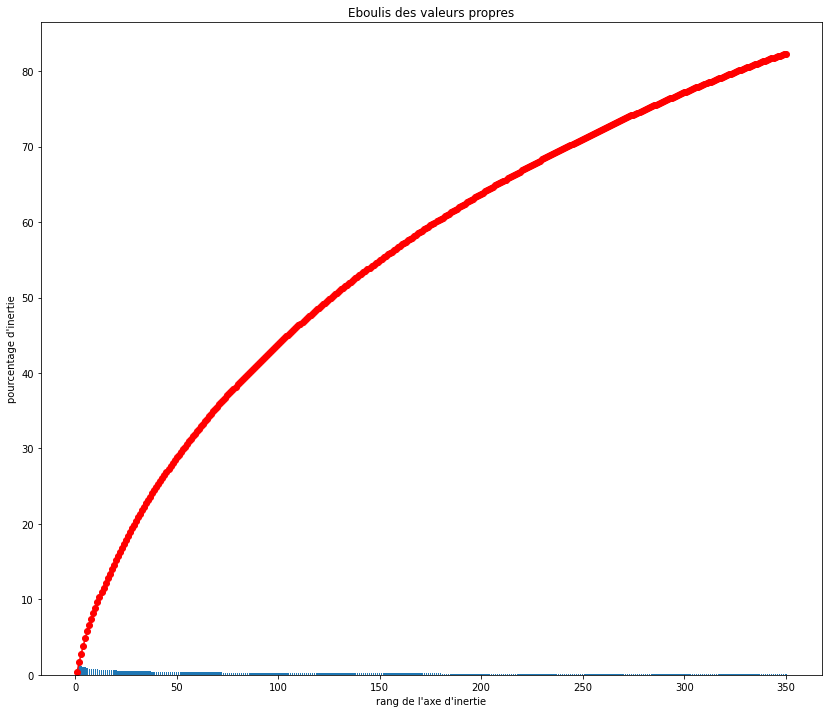

In [9]:
display_scree_plot(transformer.truncated_svd)

# Evaluation

For each experiment, we will calculate the following metrics:
* *weighted Recall*: our objective is to minimize the number of *false negatives*, which would result in a higher *recall* score. We are facing and imbalanced repartition of classes, therefore we will use the *weighted* version of the score.
* *ratio of tags hit*: in combination with the *recall score*, we will compute the number of tags that have been found amongst the filtered *tags*, the equivalent of the accuracy for each document, and calcalute its *mean* as the *ratio of tags hit*,
* *inference time*: the average time to infer a document of the *test set* in seconds,
* *model size*: the size of the model in megabytes.

We create a class to evaluate and keep track of our experiments results:

In [10]:
def count_values(y_true, y_hat):

    y_true = y_true.split(',')
    y_hat = list(y_hat)
    score_max = len(y_true)
    score = 0

    for pred in y_hat:

        if pred in y_true:

            score += 1

    return score / score_max


class PerformanceReport():

    def __init__(self):
        
        # Initialize our report DataFrame
        self.columns = [
            'Precision',
            'Recall',
            'F1',
            'Inference_time',
            'Model_size_mb',
            'Tags_hit']
        self.report = pd.DataFrame(columns=self.columns)

    def evaluate(self, name:str, model, X_test:np.array, y_true:np.array, y_pred:np.array):
        
        # Predict with the model
        tic()
        model.predict(X_test)
        # Calculate time spent
        inference_time = toc() / X_test.shape[0]
        # Dump model to disk
        dump(model, './model.joblib')
        # Get model file size
        model_size = round(os.path.getsize('./model.joblib') / 1000000)
        # Calculate the scores
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        # Append the scores to our report
        self.report.loc[name,self.columns[:-1]] = [
            precision,
            recall,
            f1,
            inference_time,
            model_size]
            
        print(pd.DataFrame(self.report.loc[name,self.columns[:-1]]))

    def tags_ratio(self, name:str, df:pd.DataFrame, y_true:str):

        scores = df.apply(lambda x: count_values(x[y_true], x[name]), axis=1)
        self.report.loc[name, 'Tags_hit'] = np.mean(scores)
        print(f"Ratio of tags hit: {round(self.report.loc[name,'Tags_hit'], 4)}")

    def get(self):

        return self.report


report = PerformanceReport()

# Modelling

## Unsupervised

### LDA

For the preprocessing of the data used by the LDA model, we are going to use the included *gensim* library methods.\
Moreover, we will not be able to calculate the standard metrics that we choosed to compare the *supervised machine learning algorithms* as we do not use the *y* data for predicting.

We create a dictionnary with the data and convert it to a bag of words corpus:

In [11]:
texts_train = transformer.X_train_raw.str.split(',')
dictionary = corpora.Dictionary(texts_train)
dictionary.filter_extremes(no_below=1000)
corpus_train = [dictionary.doc2bow(text) for text in texts_train]
tfidf = TfidfModel(corpus_train)
corpus_train = [tfidf[text] for text in corpus_train]

We test various N topics in order to calculate the coherence and perplexity scores:

In [12]:
topics_range = list(range(10, 200, 10))
coherence_scores = list()
perplexity_scores = list()
models = list()

for n_topics in topics_range:

    lda_model = LdaMulticore(
        corpus=corpus_train,
        id2word=dictionary,
        num_topics=n_topics,
        random_state=42,
        passes=10,
        workers=24)
    models.append(lda_model)

    perplexity_scores.append(lda_model.log_perplexity(corpus_train))

    coherence_model = CoherenceModel(
        model=lda_model, 
        texts=texts_train,
        dictionary=dictionary,
        coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=topics_range, y=coherence_scores, name='Coherence'),
    secondary_y=False)
fig.add_trace(
    go.Scatter(x=topics_range, y=perplexity_scores, name='Perplexity'),
    secondary_y=True)
fig.update_layout(title_text=f"Scores per n topics")
fig.update_xaxes(title_text='n topics')
fig.update_yaxes(title_text="Coherence score", secondary_y=False)
fig.update_yaxes(title_text="Perplexity score", secondary_y=True)
fig.update_layout(height=600)
fig.show()

The coherence score hits its maximum with 60 topics, we fit a model accordingly:

In [13]:
lda_model = LdaMulticore(
    corpus=corpus_train,
    id2word=dictionary,
    num_topics=80,
    random_state=42,
    passes=10,
    workers=24)

We can display the generated *topics* and their *term frequencies* using the pyLDAvis library:

In [14]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus_train, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Ca

In order to use the *LDA* model to make predictions, we develop a function to select 5 predictions by prioritizing terms that are present in the *title* of the question.\
If this does not make up for 5 *tags*, we select the terms with the highest frequencies until we obtain 5 terms.

In [15]:
def filter_preds(document, preds, length=5):
    
    filtered_preds = list()

    if type(document) == float:

        pass

    else:

        for pred in preds:

            if pred in document:

                filtered_preds.append(pred)
                preds.remove(pred)

        filtered_preds = filtered_preds[:length]

    for pred in preds:

        if len(filtered_preds) == length:
            
            break
        
        else:

            filtered_preds.append(pred)
    
    return filtered_preds

We predict the *tags* for each *document* of the *corpus* using the *get_topic_terms* method after translating the *X_test set* to a *bag of words* using the training *dictionary*.\
We then apply the *filter_preds* function described above:

In [23]:
texts_test = transformer.X_test_raw.str.split(',')
corpus_test = [dictionary.doc2bow(text) for text in texts_test]
topics = [sorted(topic, key= lambda tup: tup[1])[-1][0] for topic in lda_model.get_document_topics(corpus_test)]
preds = [[dictionary[tag[0]] for tag in lda_model.get_topic_terms(topicid=topic, topn=50)] for topic in topics]
transformer.test_df['LDA'] = preds
transformer.test_df['LDA'] = transformer.test_df.apply(lambda x: filter_preds(transformer.top_tags, x['LDA']), axis=1)
transformer.test_df[['Title_tokens', 'Tags_tokens', 'LDA']]

,Title_tokens,Tags_tokens,LDA
199,"strategy,audit,trail/change,history,db,applica...","database,postgresql,database-design,crud,audit...","[database, sql, class, list, object]"
39489,"strcmp,string,:compare","c++,c,string,char,string-comparison","[text, file, database, object, jquery]"
42724,"decode,entity,rail","ruby-on-rails,ruby,ruby-on-rails-3,html-entiti...","[function, class, object, string, c++]"
10822,"pointer,structure","c,pointers,variables,struct,return","[c, function, file, object, .net]"
4144,"use,http,authentication,client,web,service","java,web-services,ssl,cxf,ws-security","[http, file, database, object, function]"
...,...,...,...
43515,"difference,appdelegate.m,view,controller.m","iphone,objective-c,xcode,delegates,viewcontroller","[object, class, file, list, javascript]"
26859,"center,mass,set,point,map,distance,point","algorithm,language-agnostic,math,geometry,topo...","[function, class, object, string, http]"
28567,class,"c#,wpf,mvvm,dependency-properties,mvvm-foundation","[class, .net, function, string, javascript]"
18707,"macro,gcc/g++,differentiate,linux,mac,osx","linux,macos,gcc,cross-platform,macros","[list, file, .net, class, object]"


We can still calculate the *ratio of tags hit* using our *PerformanceReport* class:

In [24]:
report.tags_ratio('LDA', transformer.test_df, 'Tags_tokens')

Ratio of tags hit: 0.0688


# Supervised

### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

logr_model = OneVsRestClassifier(LogisticRegression(solver='lbfgs'))
logr_model.fit(X_train, y_train)

#estimate the best predicted tags
preds = logr_model.predict(X_test)
report.evaluate('SVM', logr_model, X_test, y_test, preds)

KeyboardInterrupt: 

In [ ]:
transformer.join_predictions('LogR', preds).head()

,Title_Body_tokens,Tags_tokens,LogR
199,"strategy,audit,trail/change,history,db,applica...","database,postgresql,database-design,crud,audit...","(database,)"
39489,"strcmp,string,:compare,compare,string,seem,wor...","c++,c,string,char,string-comparison",()
42724,"decode,entity,rail,duplicate,encode/decode,ent...","ruby-on-rails,ruby,ruby-on-rails-3,html-entiti...","(ruby-on-rails, ruby, entity-framework)"
10822,"pointer,structure,return,pointer,struct,c,mean...","c,pointers,variables,struct,return","(c++, c, pointers)"
4144,"use,http,authentication,client,web,service,acc...","java,web-services,ssl,cxf,ws-security","(security, web-services, wcf, ssl)"


In [ ]:
report.tags_ratio('LogR', transformer.test_df, 'Tags_tokens')

Ratio of tags hit: 0.2066


### SVM

In [ ]:
svm_model = OneVsRestClassifier(LinearSVC())
svm_model.fit(X_train, y_train)
preds = svm_model.predict(X_test)
report.evaluate('SVM', svm_model, X_test, y_test, preds)

KeyboardInterrupt: 

In [ ]:
transformer.join_predictions('SVM', preds).head()

,Title_Body_tokens,Tags_tokens,SVM
199,"strategy,audit,trail/change,history,db,applica...","database,postgresql,database-design,crud,audit...","(database,)"
39489,"strcmp,string,:compare,compare,string,seem,wor...","c++,c,string,char,string-comparison",()
42724,"decode,entity,rail,duplicate,encode/decode,ent...","ruby-on-rails,ruby,ruby-on-rails-3,html-entiti...","(ruby-on-rails, ruby, entity-framework)"
10822,"pointer,structure,return,pointer,struct,c,mean...","c,pointers,variables,struct,return","(c++, c, pointers)"
4144,"use,http,authentication,client,web,service,acc...","java,web-services,ssl,cxf,ws-security","(security, web-services, wcf, ssl)"


In [ ]:
report.tags_ratio('SVM', transformer.test_df, 'Tags_tokens')

Ratio of tags hit: 0.2434


### SGD

LOSS = modified huber\
logistic regression -> solver lbsds

In [ ]:
sgd_model = OneVsRestClassifier(SGDClassifier(loss='modified_huber'), n_jobs=-1)
sgd_model.fit(X_train, y_train)
preds = sgd_model.predict(X_test)
report.evaluate('SGD', sgd_model, X_test, y_test, preds)

                     SGD
Precision       0.667912
Recall          0.349676
F1              0.437114
Inference_time  0.000085
Model_size_mb          1


/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
transformer.join_predictions('SGD', preds).head()

,Title_Body_tokens,Tags_tokens,SGD
199,"strategy,audit,trail/change,history,db,applica...","database,postgresql,database-design,crud,audit...","(database,)"
39489,"strcmp,string,:compare,compare,string,seem,wor...","c++,c,string,char,string-comparison",()
42724,"decode,entity,rail,duplicate,encode/decode,ent...","ruby-on-rails,ruby,ruby-on-rails-3,html-entiti...","(ruby-on-rails, ruby, entity-framework)"
10822,"pointer,structure,return,pointer,struct,c,mean...","c,pointers,variables,struct,return","(c++, c, pointers)"
4144,"use,http,authentication,client,web,service,acc...","java,web-services,ssl,cxf,ws-security","(security, web-services, wcf, ssl)"


We notice that some *documents* have empty predictions.\
This behavior is unwanted, as we want to offer predictions for all the questions passed to the model. We will try to remediate to this issue in the next part.

In [ ]:
report.tags_ratio('SGD', transformer.test_df, 'Tags_tokens')

Ratio of tags hit: 0.2428


### KNN

In [28]:
knn_model = KNeighborsClassifier(n_neighbors=25, leaf_size=90, weights='distance')
knn_model.fit(X_train.values, y_train.values)
preds = knn_model.predict(X_test)
report.evaluate('KNN', knn_model, X_test, y_test, preds)

                     KNN
Precision       0.614317
Recall          0.109771
F1              0.176203
Inference_time  0.000383
Model_size_mb         89


/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [29]:
transformer.join_predictions('KNN', preds).head()

,Title_Body_tokens,Tags_tokens,KNN
199,"strategy,audit,trail/change,history,db,applica...","database,postgresql,database-design,crud,audit...",()
39489,"strcmp,string,:compare,compare,string,seem,wor...","c++,c,string,char,string-comparison",()
42724,"decode,entity,rail,duplicate,encode/decode,ent...","ruby-on-rails,ruby,ruby-on-rails-3,html-entiti...",()
10822,"pointer,structure,return,pointer,struct,c,mean...","c,pointers,variables,struct,return","(c++, c, pointers)"
4144,"use,http,authentication,client,web,service,acc...","java,web-services,ssl,cxf,ws-security","(web-services,)"


In [30]:
report.tags_ratio('KNN', transformer.test_df, 'Tags_tokens')

Ratio of tags hit: 0.0762


We obtain interesting results, a few rows have actually been predicted by the model, this is because the model outputs low porbabilities for most of its predictions.

In order to obtain 5 tags, we are going to use the *predict_proba* method to output predictions with lower probability, using the following function:

In [31]:
def get_firsts(preds_proba, n_first=5):

    result = np.array([
        np.where(pred >= np.partition(pred, -n_first)[-n_first], 1, 0)
        for pred in np.array([pred[:,1] for pred in preds_proba
        ]).transpose()])

    return result

As we generate more predictions for each row, it is normal to observe a consequent drop in *precision*:

In [32]:
preds_proba = knn_model.predict_proba(X_test.values)
preds_firsts = get_firsts(preds_proba)
report.evaluate('KNN_5', knn_model, X_test, y_test, preds_firsts)

                   KNN_5
Precision       0.385571
Recall          0.474235
F1              0.384409
Inference_time  0.000392
Model_size_mb         89


In [33]:
transformer.join_predictions('KNN_5', preds_firsts).head()

,Title_Body_tokens,Tags_tokens,KNN_5
199,"strategy,audit,trail/change,history,db,applica...","database,postgresql,database-design,crud,audit...","(c#, sql, sql-server, database, sql-server-2005)"
39489,"strcmp,string,:compare,compare,string,seem,wor...","c++,c,string,char,string-comparison","(c#, .net, c++, iphone, objective-c)"
42724,"decode,entity,rail,duplicate,encode/decode,ent...","ruby-on-rails,ruby,ruby-on-rails-3,html-entiti...","(c#, java, .net, jpa, entity-framework)"
10822,"pointer,structure,return,pointer,struct,c,mean...","c,pointers,variables,struct,return","(c#, c++, c, arrays, pointers)"
4144,"use,http,authentication,client,web,service,acc...","java,web-services,ssl,cxf,ws-security","(c#, security, web-services, wcf, ssl)"


In [34]:
report.tags_ratio('KNN_5', transformer.test_df, 'Tags_tokens')

Ratio of tags hit: 0.3292


We encapsulte our *filter_preds* method in order to be able to sort the results of the *predict_proba* method and apply it to the matrix output, using the transformers *MultiLabelBinarizer* to inverse tranform the predictions:

In [35]:
def select_preds(name, transformer: DatasetTransformer, preds_proba):

    preds_df = pd.DataFrame(np.array([pred[:,1] for pred in preds_proba]).transpose(),columns=transformer.multi_label_binarizer.classes_)
    preds_lists = preds_df.apply(lambda x: x[x > 0].sort_values(ascending=False).keys().to_list(), axis=1)
    preds_array = transformer.multi_label_binarizer.transform(preds_lists.values)
    transformer.test_df[name] = preds_lists.values
    transformer.test_df[name] = transformer.test_df.apply(lambda x: filter_preds(x['Title_Body_tokens'], x[name]), axis=1)

    return preds_array, transformer.test_df

In [36]:
preds_select, preds_df = select_preds('KNN_select', transformer, preds_proba)
report.evaluate('KNN_select', knn_model, X_test, y_test, preds_select)

               KNN_select
Precision        0.103705
Recall           0.831817
F1               0.180451
Inference_time   0.000397
Model_size_mb          89


In [37]:
preds_df[['Title_Body_tokens', 'Tags_tokens', 'KNN_select']].head()

,Title_Body_tokens,Tags_tokens,KNN_select
199,"strategy,audit,trail/change,history,db,applica...","database,postgresql,database-design,crud,audit...","[sql, database, sql-server, sql-server-2005, c#]"
39489,"strcmp,string,:compare,compare,string,seem,wor...","c++,c,string,char,string-comparison","[c++, c, string, c#, iphone]"
42724,"decode,entity,rail,duplicate,encode/decode,ent...","ruby-on-rails,ruby,ruby-on-rails-3,html-entiti...","[ruby, string, entity-framework, c#, .net]"
10822,"pointer,structure,return,pointer,struct,c,mean...","c,pointers,variables,struct,return","[c, pointers, c++, arrays, c#]"
4144,"use,http,authentication,client,web,service,acc...","java,web-services,ssl,cxf,ws-security","[security, authentication, web-services, ssl, c#]"


In [38]:
report.tags_ratio('KNN_select', transformer.test_df, 'Tags_tokens')

Ratio of tags hit: 0.369


As we can see, the strategy of priotizing the selection of the *predictions* that are present in the question content is effective, as we hit more actual *tags*.

### Random Forest

In [ ]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)
preds = rfc_model.predict(X_test)
preds_proba = rfc_model.predict_proba(X_test)
report.evaluate('Random_Forest', rfc_model, X_test, y_test, preds)

               Random_Forest
Precision                0.0
Recall                   0.0
F1                       0.0
Inference_time      0.000652
Model_size_mb           1249


/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
transformer.join_predictions('Random_Forest', preds).head()

,Title_Body_tokens,Tags_tokens,Random_Forest
199,"strategy,audit,trail/change,history,db,applica...","database,postgresql,database-design,crud,audit...",()
39489,"strcmp,string,:compare,compare,string,seem,wor...","c++,c,string,char,string-comparison",()
42724,"decode,entity,rail,duplicate,encode/decode,ent...","ruby-on-rails,ruby,ruby-on-rails-3,html-entiti...",()
10822,"pointer,structure,return,pointer,struct,c,mean...","c,pointers,variables,struct,return",()
4144,"use,http,authentication,client,web,service,acc...","java,web-services,ssl,cxf,ws-security",()


In [ ]:
report.tags_ratio('Random_Forest', transformer.test_df, 'Tags_tokens')

Ratio of tags hit: 0.0


In [ ]:
preds_firsts = get_firsts(preds_proba, 5)
report.evaluate('Random_Forest_5', rfc_model, X_test, y_test, preds_firsts)

               Random_Forest_5
Precision             0.398853
Recall                 0.32175
F1                    0.226886
Inference_time        0.000657
Model_size_mb             1249


/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
transformer.join_predictions('Random_Forest_5', preds_firsts).head()

,Title_Body_tokens,Tags_tokens,Random_Forest_5
199,"strategy,audit,trail/change,history,db,applica...","database,postgresql,database-design,crud,audit...","(java, sql, sql-server, mysql, database)"
39489,"strcmp,string,:compare,compare,string,seem,wor...","c++,c,string,char,string-comparison","(c#, java, c++, javascript, python)"
42724,"decode,entity,rail,duplicate,encode/decode,ent...","ruby-on-rails,ruby,ruby-on-rails-3,html-entiti...","(java, c++, ruby-on-rails, ruby, ruby-on-rails-3)"
10822,"pointer,structure,return,pointer,struct,c,mean...","c,pointers,variables,struct,return","(java, c++, python, c, pointers)"
4144,"use,http,authentication,client,web,service,acc...","java,web-services,ssl,cxf,ws-security","(c#, java, .net, web-services, ssl)"


In [ ]:
report.tags_ratio('Random_Forest_5', transformer.test_df, 'Tags_tokens')

Ratio of tags hit: 0.2234


In [ ]:
preds_select, preds_df = select_preds('Random_Forest_select', transformer, preds_proba)
report.evaluate('Random_Forest_select', rfc_model, X_test, y_test, preds_select)

               Random_Forest_select
Precision                  0.058261
Recall                          1.0
F1                         0.102722
Inference_time             0.000646
Model_size_mb                  1249


In [ ]:
preds_df[['Title_Body_tokens', 'Tags_tokens', 'Random_Forest_select']].head()

,Title_Body_tokens,Tags_tokens,Random_Forest_select
199,"strategy,audit,trail/change,history,db,applica...","database,postgresql,database-design,crud,audit...","[sql, postgresql, c, r, sql-server]"
39489,"strcmp,string,:compare,compare,string,seem,wor...","c++,c,string,char,string-comparison","[c++, c, string, com, r]"
42724,"decode,entity,rail,duplicate,encode/decode,ent...","ruby-on-rails,ruby,ruby-on-rails-3,html-entiti...","[ruby, c, string, function, r]"
10822,"pointer,structure,return,pointer,struct,c,mean...","c,pointers,variables,struct,return","[c, r, c++, java, python]"
4144,"use,http,authentication,client,web,service,acc...","java,web-services,ssl,cxf,ws-security","[security, http, c, r, c#]"


In [ ]:
report.tags_ratio('Random_Forest_select', transformer.test_df, 'Tags_tokens')

Ratio of tags hit: 0.2528


# Exploring the results

In [ ]:
report.get()

,Precision,Recall,F1,Inference_time,Model_size_mb,Tags_hit
SVM,0.667811,0.350586,0.442996,0.000083,1,0.243396
SGD,0.667912,0.349676,0.437114,0.000085,1,0.242764
KNN,0.632555,0.110169,0.176991,0.000389,89,0.076486
KNN_5,0.384411,0.473951,0.383665,0.000381,89,0.329042
KNN_select,0.103802,0.83267,0.18061,0.000386,89,0.368766
Random_Forest,0.352745,0.004379,0.008523,0.000686,8268,0.00304
Random_Forest_5,0.388243,0.454499,0.328078,0.000942,8268,0.315538
Random_Forest_select,0.061741,0.95211,0.109372,0.00097,8268,0.310839


The *KNN_select* model offers a good performance, a good *recall* score, while remaining of light size, for these reasons we are going to implement this model in our *API*.

The following cell, when executed, pulls a random *sample* from the dataset to explore the behavior of the *KNN_select* (the *supervised tags*, compared to the *LDA unsupervised tags*):

In [ ]:
preds_df = transformer.test_df

sample = preds_df.sample(1)
print(f"""
    Title: {sample['Title_tokens'].values[0]}\n\n
    Body: {sample['Body_tokens'].values[0]}\n\n
    Tags: {sample['Tags_tokens'].values[0]}\n\n
    Unsupervised tags: {sample['LDA'].values[0]}\n\n
    Supervised tags: {sample['KNN_select'].values[0]}""")

KeyError: 'LDA'

We can observe that the *LDA* model mainly pulls generic terms from the *document*, which is not, in our case, a wanted behavior. The *KNN_select* predictions seem way more pertinent.

# Saving files

*For further use*

In [ ]:
X_train.to_csv('./X_train.csv')
X_test.to_csv('./X_test.csv')
y_train.to_csv('./y_train.csv')
y_test.to_csv('./y_test.csv')

In [40]:
dump(transformer.multi_label_binarizer, './api/multi_label_binarizer.joblib')
dump(transformer.tfid_vectorizer, './api/tfid_vectorizer.joblib')
dump(transformer.truncated_svd, './api/truncated_svd.joblib')
dump(knn_model, './api/model.joblib')

['./api/model.joblib']

In [ ]:
stop

NameError: name 'stop' is not defined